## The objective of this notebook is to explore the profitablilty of a rolling cummlative trading strategy.

 Get imports

In [1]:
from jupyterthemes import jtplot
jtplot.style()
import plotly
from plotly import __version__
print(__version__)
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.tools as tls
import matplotlib.pyplot as plt
import pandas as pd
import portmaker
import numpy as np
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

4.0.0


# Plotting functions
using plotly for later dash visualizations!

In [14]:

def plot_signal(prices,signal):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=prices.index, y=prices['Close'], name="Close"))

    fig.add_trace(go.Scatter(x=prices.index, y=prices['2'], name="High"))
    fig.add_trace(go.Scatter(x=prices.index, y=prices['-2'], name="Low"))
    fig.add_trace(go.Scatter(x=prices.index, y=signal['Position'], name="Signal",)
    ,secondary_y=True)

    fig.layout.update(title='BTC Signal')#,xaxis_rangeslider_visible=True)
    # Set x-axis title
    fig.update_xaxes(title_text="Date")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Price</b> ", secondary_y=False)
    fig.update_yaxes(title_text="<b>Signal</b>", secondary_y=True)
    
    fig.show()
    
def plot_returns(prices, all_sigs):
    all_sigs['Market Return'] = np.log(all_sigs["Close"] / all_sigs["Close"].shift(1))
    all_sigs['Strategy Return'] = all_sigs['Market Return'] * all_sigs['Position']
    all_sigs['Strategy Return'] = all_sigs['Strategy Return']*100
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=prices.index, y=all_sigs['Strategy Return'].cumsum(), name="Returns", line_color='deepskyblue'))
    fig.update_layout(title_text='Returns',
                  xaxis_rangeslider_visible=True)
    fig.show()
    
def animate_returns(prices, all_sigs):                         
    fig = go.Figure(
        data=[go.Scatter(x=prices.index, y=all_sigs['Strategy Return'], name="Returns", line_color='deepskyblue')],
        layout=go.Layout(
            title_text='Returns', hovermode="closest",
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]),
        frames=[go.Frame(
            data=[go.Scatter(x=prices.index,
                y=all_sigs['Strategy Return'],
                name="Returns",
                mode="markers",
                marker=dict(color="red", size=10))])

            for k in range(len(prices))]
    )

    fig.show()

# Download 30 day historical price data
Using 1 hour granualarity


In [12]:
end = int(portmaker.current_milli_time())
d_intv = 30
st = end-(86400000*d_intv)
coin = "BTCUSDT"
candle_k='1h'
data = portmaker.get_data(coin,st,end,candle_k='1h')

# Create interval data for signals
### create signals with interval data via portmaker

Creating: 3 day intervals over 30 days data 
2019-07-05 05:00:00 2019-07-08 05:00:00
2019-07-08 05:00:00 2019-07-11 05:00:00
2019-07-11 05:00:00 2019-07-14 05:00:00
2019-07-14 05:00:00 2019-07-17 05:00:00
2019-07-17 05:00:00 2019-07-20 05:00:00
2019-07-20 05:00:00 2019-07-23 05:00:00
2019-07-23 05:00:00 2019-07-26 05:00:00
2019-07-26 05:00:00 2019-07-29 05:00:00
2019-07-29 05:00:00 2019-08-01 05:00:00
2019-08-01 05:00:00 2019-08-03 22:00:05.307000


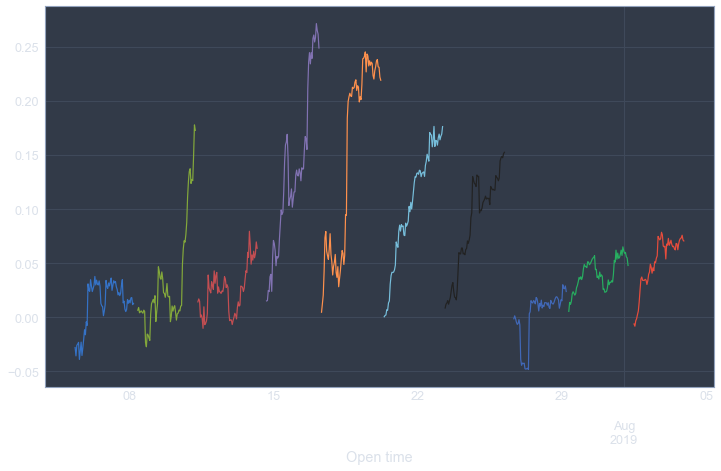

In [13]:
dt_intv=72#48
intv_dates = data.index[::dt_intv]#.to_list()
all_sigs = pd.DataFrame()
all_prices = pd.DataFrame()
last_id = len(intv_dates)-1
print("Creating: {} day intervals over {} days data ".format(str(int(dt_intv/24)),str(int(d_intv))))
for c,i in enumerate(intv_dates):

    st = i 
    try:
        end = intv_dates[c+1]
    except:
        end = portmaker.to_dt(int(portmaker.current_milli_time()))
    print(st,end)
    intv_data =data[st:end]
    high = intv_data.High
    prices = intv_data #[:intv].High

    prices = portmaker.make_bands(prices,high)
    signal = portmaker.make_signal(prices,coin)
    all_sigs = pd.concat([all_sigs,signal]).fillna(method='ffill')
    all_prices = pd.concat([all_prices,prices])
print("\nPlot individual interval returns\n")

# Create interactive plots for signal analysis

In [15]:
plot_signal(all_prices,all_sigs)
plot_returns(all_prices,all_sigs)

# Check last n day strategy performance
-- using hourly granaulaity

In [19]:
i = 96
ret = all_sigs['Strategy Return'].iloc[-i:-1].cumsum()
ret = round(float(ret.iloc[-1]),2)
print("Past: {} day returns: {}% ".format(str(int(i/24)),ret))
ld = all_sigs.index.values
print("Last datetime entered: {}".format(ld[-1]))
plot_signal(all_prices[-i:-1],all_sigs[-i:-1])
plot_returns(all_prices[-i:-1],all_sigs[-i:-1])

Past: 4 day returns: 9.91% 
Last datetime entered: 2019-08-03T22:00:00.000000000


In [9]:
print("Last signal: ",all_sigs["Position"].iloc[-1])

Last signal:  1.0


# Explore different time granualarity for interval trading
#### -1 day
#### -12 hr
#### -4 hr
#### -1 hr
#### -5 min
#### -1 min

In [ ]:
intvs = ['1d','12h','4h','1h','5m','1m']
end = int(portmaker.current_milli_time())
endc = end

coin = "BTCUSDT"
for ck in intvs:
    st = endc-(86400000*30)
    intv_data = portmaker.get_data(coin,st,endc,candle_k=ck)
    #select 2 day intervals
    if (ck=='1m'):
        dt_intv = 4320
    if (ck=='5m'):
        dt_intv = 864
    if (ck=='1h'):
        dt_intv = 72
    if (ck=='4h'):
        dt_intv = 18
    if (ck=='12h'):
        dt_intv = 6
    if (ck=='1d'):
        dt_intv = 3

    intv_dates = intv_data.index[::dt_intv].to_list()
    intv_sigs = pd.DataFrame()
    intv_prices = pd.DataFrame()
    last_id = len(intv_dates)-1
    for c,i in enumerate(intv_dates):

        st = i 
        try:
            end = intv_dates[c+1]
        except:
            end = portmaker.to_dt(int(portmaker.current_milli_time()))
        #print(st,end)
        intv_data = data[st:end]
        high = intv_data.High
        prices = intv_data #[:intv].High

        try:
            prices = portmaker.make_bands(prices,high)
            signal = portmaker.make_signal(prices,coin)
            intv_sigs = pd.concat([intv_sigs,signal]).fillna(method='ffill')
            intv_prices = pd.concat([intv_prices,prices])
        except:
            continue
    print(ck," ",coin)
    plot_signal(intv_prices,intv_sigs)
    plot_returns(intv_prices,intv_sigs)
   